In [ ]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate #there's probably more here if reqd for google colab but I'll work it out later

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.7 MB/s eta 0:00:00


In [4]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

from PIL import Image
import requests
from io import BytesIO
import numpy as np


# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

import torch.nn.functional as F
torch.manual_seed(1)
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Stable Diffusion explainer!

Hello! welcome to my explainer for stable diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how Latent Diffusion Models work, specifically focusing on Stable Diffusion v1.4, as it's probably the most intuitive to explain. 

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the first section out of 5: a high level explanation of the model cascade. The other sections are accessible here:

1. Intro to the architecture
2. CLIP Text embedder
3. Variational AutoEncoder
4. UNet denoiser
5. Conclusion - putting it all together

*turn these into links eventually*

# Part 3: Variational AutoEncoder

Let's take a look at the image compression model now, which in this case is a Variational Auto-Encoder (or VAE). First we'll load it, then we'll take a look at how it works.

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae = vae.to(torch_device).half()


First let's just demonstrate how it works as initially designed - let's compress and then decompress an image. For no reason whatsoever, let's load an image of Elon Musk up as an example.

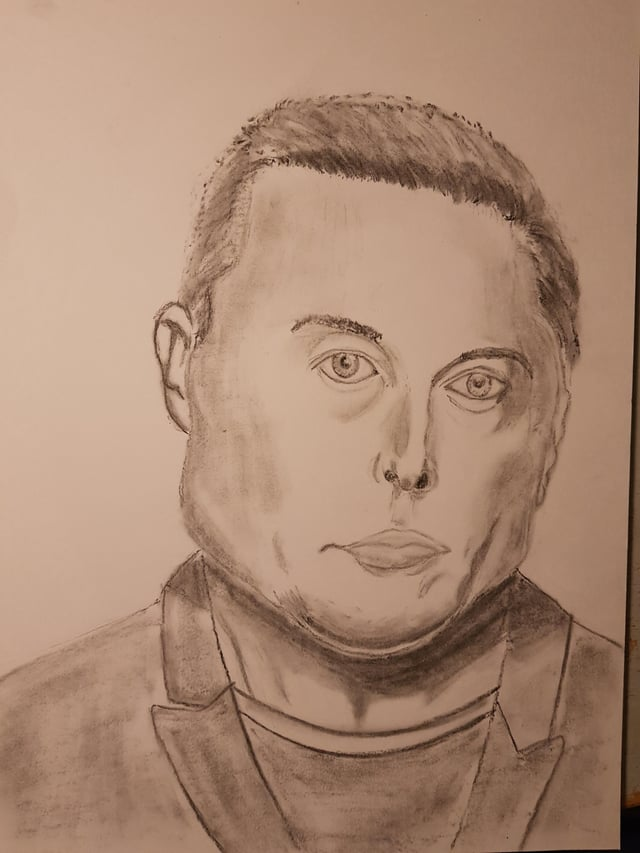

In [6]:
elonURL = requests.get('https://preview.redd.it/twsliey41yk21.jpg?width=640&crop=smart&auto=webp&s=19e34b31877d410d141c019faad30d967caffa16')
elonImg = Image.open(BytesIO(elonURL.content))
elonImg

For the sake of this demo - since this VAE has been designed with 512x512 images in mind, let's square up this image and then compress it into 512x512 resolution.

In [7]:
elonImg=elonImg.crop((0,50,640,690))
elonImg=elonImg.resize((512,512))

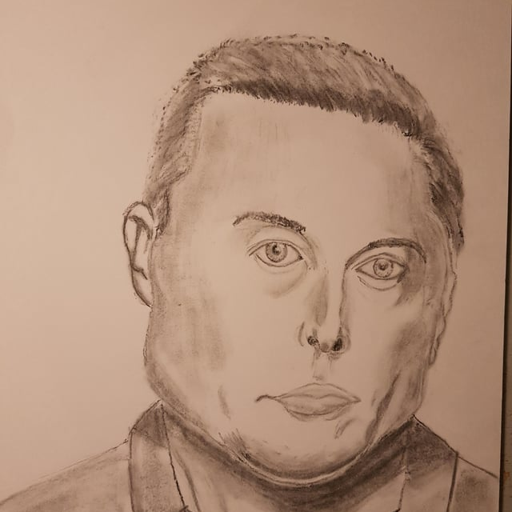

In [8]:
elonImg

As an additional demonstration, we'll resize this image to 64x64 pixels, and then bring it back up again to 512x512. We'll use this as a point of comparison between the VAE decoder and a "traditional" image compression algorithm. We're picking 64x64 because this is the dimension of outputs of the VAE encoder (i.e., this is the "resolution" of the latent space of the VAE encoder-decoder).

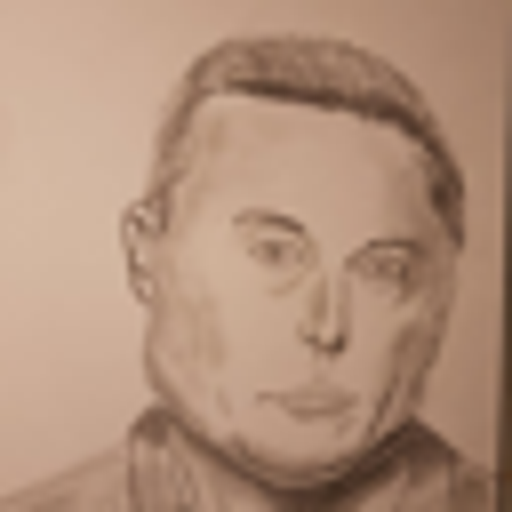

In [9]:
elonImg_compressed=elonImg.resize((64,64))
elonImg_compressed=elonImg_compressed.resize((512,512))
elonImg_compressed

Wow - looks pretty blurry huh. Now let's try compressing him through the VAE.

In [10]:
# Function for turning an image into a VAE input
def img2VAETensor(PILImage):
    PILImage=PILImage.convert('RGB')
    ImgTensor=tfms.ToTensor()(PILImage).unsqueeze(0) * 2.0 - 1.0
    return ImgTensor

# make data the same precision as VAE model precision, and move to same device
elonTensor=img2VAETensor(elonImg).to(torch_device).half()


In [11]:
# VAE encoder function

def VAE_encode(VAETensor):
    init_encode=vae.encode(VAETensor)
    encoded_sample=init_encode.latent_dist.sample()*0.18215
    return encoded_sample
    
# encoding Elon
elonEncodedSample=VAE_encode(elonTensor)

In [12]:
# print out the shape
elonEncodedSample.shape

torch.Size([1, 4, 64, 64])

Looking at the shape of the encoded sample (since it's a VAE, we have to take a sample of a distribution, but I won't go into that) - we can see that there are essentially 4 channels of 64x64 data. While our original image would have been RGB, another common form of image channel data is RGBA, where the A stands for "Alpha". The Alpha channel essentially dictates channel transparency.

So in a sense, we can consider this our "resized" image. 

***A BIG NOTE*** - there is no fixed reason for an image-based Variational AutoEncoder to output an encoded sample into valid image data. This is not a valid, generaliseable assumption to make outside of this cascade of models. Conveniently though, this data actually makes a pretty good, intuitive proxy for a compressed image, so we'll run with it for an easy explanation.

let's look at the compressed image now

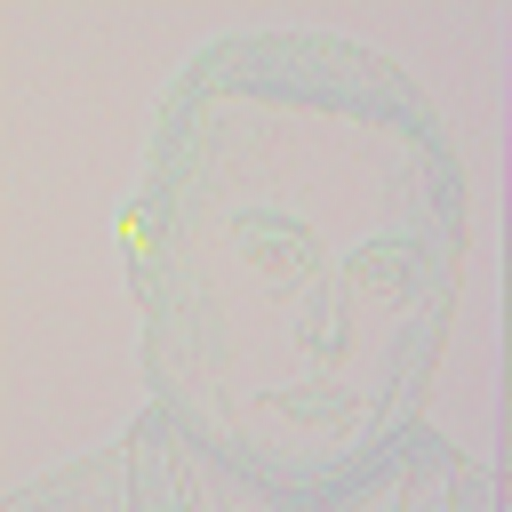

In [13]:
tensor_to_image=tfms.ToPILImage()
elonEncodedSample_normaliseRGBA=(elonEncodedSample+12)/20 #this is sort of arbitrary, forcing these pixels into a 0-1 range
tensor_to_image(elonEncodedSample_normaliseRGBA[0]).resize((512,512))

well look at that - it's all funky looking in the encoded space. But, you can clearly see there's changes in the data that correlate to features in the image itself. There are weird, coloured ridges where the lines in elon's face should be! Strange colour shift, but ignore that for now. It's a bit clearer when we look at each individual channel, so let's do that.

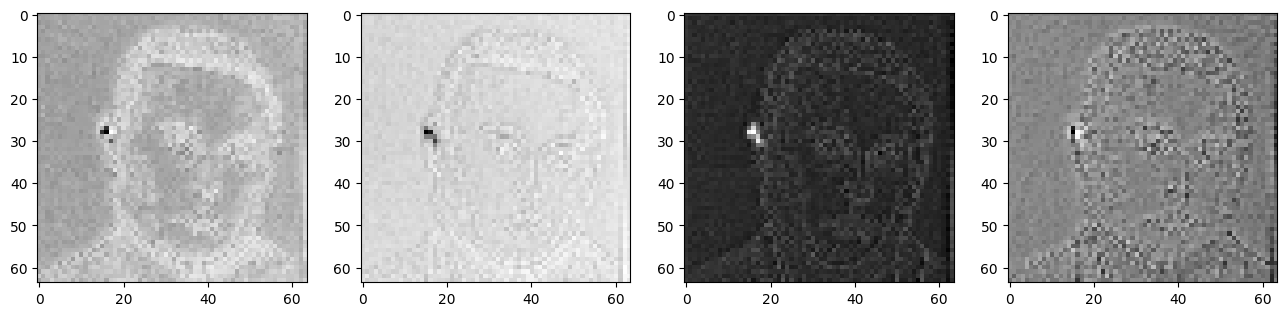

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(elonEncodedSample[0][c].detach().cpu(), cmap='Greys')

There seems to be a big hotspot at his ear - interesting to note, but not sure why that is! let's decode this image now.

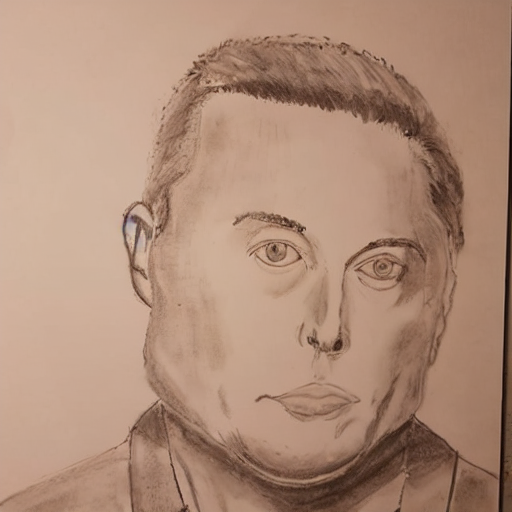

In [15]:
def VAE_decode(VAE_encoded_sample):
    rescaled_sample=(1/0.18215)*VAE_encoded_sample

    with torch.no_grad():
        decodedTensor=vae.decode(rescaled_sample).sample
    decodedTensor=(decodedTensor/2+0.5).clamp(0,1)
    decodedTensor=decodedTensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    decodedTensor=(decodedTensor * 255).round().astype("uint8")
    decodedTensorImg=Image.fromarray(decodedTensor[0])

    return decodedTensorImg

elonDecodedImg_PIL = VAE_decode(elonEncodedSample)
elonDecodedImg_PIL

wow! look at that! This is a super good result after we've compressed the image to 64x64! Let's put all these printouts in a row to compare them. The first image is the original image, the second is the traditionally resized, and the third is the VAE encoded -> decoded image.

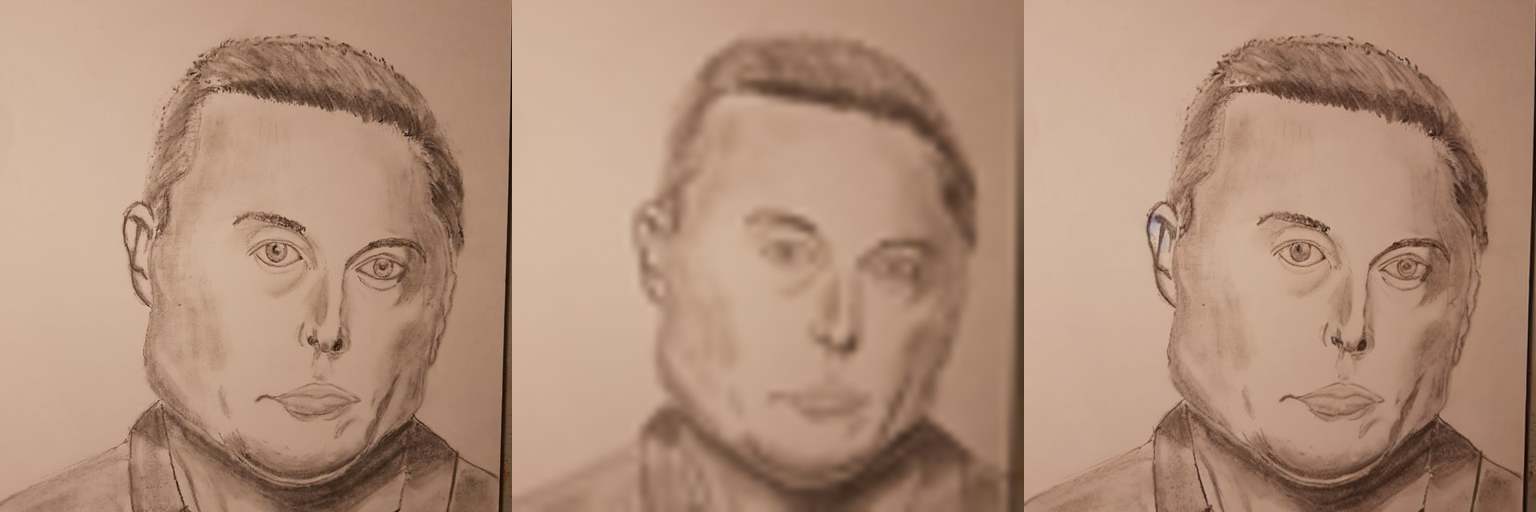

In [16]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid([elonImg, elonImg_compressed, elonDecodedImg_PIL], 1,3)

That's an extremely good result! We can clearly see here that the VAE has done a much better job of compressing the information in the original image compared to a traditional down-res of the image - the VAE output is actually extremely close to the original, despite the fact that we took it down to the same "resolution" as the middle image.

Now why did we go through all that trouble with a VAE? Well, the Denoising algorithm we use in the UNet is extremely computationally expensive when it comes to data throughput (essentially, if you put a big file through, you will potentially blow up your computer). By using a VAE, we can "down-res" the image while preserving a *lot* of the detail in the higher resolution image. This particular VAE encodes pictures to a latent space that is 64x smaller than the original image. By encoding images into this significantly smaller latent space, this makes the denoising UNet a huge amount easier to train/run - and this was the big breakthrough that made latent diffusion possible at higher resolutions in the first place.

ONE THING TO NOTE THOUGH - the above example is just a particularly good one. This model definitely has weaknesses in the kinds of features it can/cannot compress well into its latent space. After all, the latent space is still quite a low resolution.

In the below cell, I've written up a function that outputs the above trifecta of images (left is original, middle is down-ressed, right is VAE-decoded) for any image URL. NOTE: the image loader will automatically crop and resize the image to be 512x512. If the image is not square, crops will be made from the right/bottom edges (i.e. the top left corner of the image will be retained).

Play around with it and see what results you get! Specifically, try and focus on what details might be inserted into the VAE decoded image, and what details might get lost.

TO start with, here's a guide on a few images to try:
- screenshots of fine text
- Photos of faces
- landscape photos/astrophotography

In [17]:
def get_image(URL):
    ImgURL = requests.get(URL)
    Img = Image.open(BytesIO(ImgURL.content))
    
    lrdiff=Img.size[0]-min(Img.size)
    tbdiff=Img.size[1]-min(Img.size)
    Img = Img.crop((0,0,Img.size[0]-lrdiff, Img.size[1]-tbdiff))
    Img = Img.resize((512,512))
    return Img

def downres(Img):
    Img=Img.resize((64,64))
    Img=Img.resize((512,512))
    return Img

def VAE_demo(URL):
    orig_img=get_image(URL)
    downres_img=downres(orig_img)

    tensor_Img=img2VAETensor(orig_img).to(torch_device).half()
    encodedSample=VAE_encode(tensor_Img)
    decoded_img=VAE_decode(encodedSample)
    return image_grid([orig_img, downres_img, decoded_img], 1, 3)

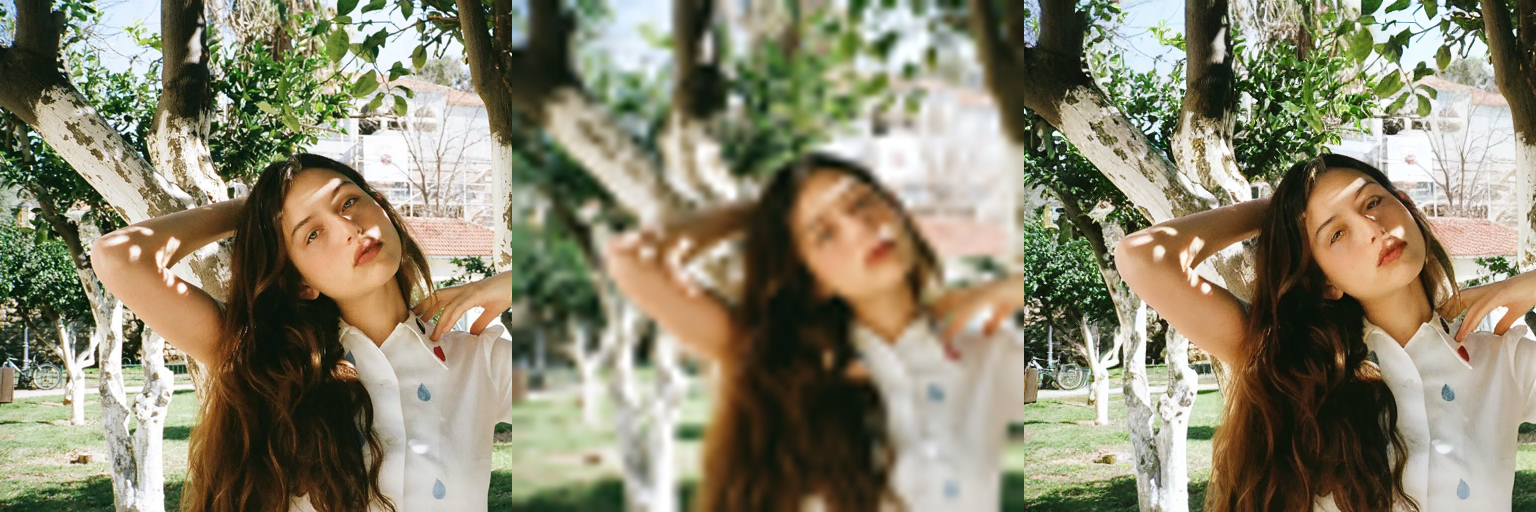

In [18]:
# ITERATE HERE
VAE_demo('https://www.format.com/wp-content/uploads/jill-schweber.jpg.webp')

Now that we've covered the VAE - let's look at our final model, the denoising UNet. *make this a link*